# Hydra and OmegaConf Configuration System for ImageDGD

This notebook demonstrates how to use **Hydra** and **OmegaConf** to create and manage YAML configuration files for the ImageDGD training pipeline.

## Configuration Files Created:
1. **`config/config.yaml`** - Default parameters
2. **`config/config_minimal.yaml`** - Fast testing configuration (10% data, 20 epochs)
3. **`config/config_detailed.yaml`** - Advanced configuration with all parameters

In [101]:
# Import necessary libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add the src directory to Python path
current_dir = Path.cwd()
# Navigate to project root regardless of where we're running from
if "notebooks" in str(current_dir):
    # If we're running from the notebooks directory
    project_root = current_dir.parent
elif current_dir.name != "ImageDGD":
    # If we're running from somewhere else, navigate to ImageDGD
    project_root = current_dir / "HeaDS" / "ImageDGD"
else:
    project_root = current_dir

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

# Import configuration utilities
from omegaconf import DictConfig, OmegaConf
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print(f"Current working directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Src path: {src_path}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Current working directory: /home/asp/Downloads
Project root: /home/asp/Downloads/HeaDS/ImageDGD
Src path: /home/asp/Downloads/HeaDS/ImageDGD/src
PyTorch version: 2.4.0
CUDA available: True


## 2. Overview of Configuration Files

We've already created three configuration files with different purposes:

### 📁 Configuration Structure
```
config/
├── config.yaml              # Default production config
├── config_minimal.yaml      # Fast testing config  
└── config_detailed.yaml     # Advanced config with all parameters
```

Let's explore each configuration file and understand their differences.

In [102]:
# Check if config files exist
# First, let's set the working directory to the project root
project_root = Path.cwd()
if "notebooks" in str(project_root):
    # If we're running from the notebooks directory
    project_root = project_root.parent
elif project_root.name != "ImageDGD":
    # If we're running from somewhere else, navigate to ImageDGD
    project_root = project_root / "HeaDS" / "ImageDGD"

config_dir = project_root / "config"
config_files = {
    "Default": config_dir / "config.yaml",
    "Minimal": config_dir / "config_minimal.yaml", 
    "Detailed": config_dir / "config_detailed.yaml"
}

print("📁 Configuration files status:")
for name, path in config_files.items():
    if path.exists():
        size_kb = path.stat().st_size / 1024
        print(f"✓ {name:8} config: {path} ({size_kb:.1f} KB)")
    else:
        print(f"✗ {name:8} config: {path} (NOT FOUND)")

# Also check if all config files exist
print(f"\n📁 All configuration files found: {len(config_files)} files")

📁 Configuration files status:
✓ Default  config: /home/asp/Downloads/HeaDS/ImageDGD/config/config.yaml (2.7 KB)
✓ Minimal  config: /home/asp/Downloads/HeaDS/ImageDGD/config/config_minimal.yaml (2.7 KB)
✓ Detailed config: /home/asp/Downloads/HeaDS/ImageDGD/config/config_detailed.yaml (6.2 KB)

📁 All configuration files found: 3 files


## 3. Load and Parse Configuration with OmegaConf

Now let's demonstrate how to load and work with these YAML configurations using OmegaConf.

In [103]:
# Load different configurations
configs = {}

for name, path in config_files.items():
    if path.exists():
        try:
            config = OmegaConf.load(path)
            configs[name] = config
            print(f"✓ Loaded {name} configuration")
        except Exception as e:
            print(f"✗ Failed to load {name} configuration: {e}")
    else:
        print(f"✗ {name} configuration file not found")

print(f"\nSuccessfully loaded {len(configs)} configurations")

# Let's examine the minimal config structure
if "Minimal" in configs:
    minimal_config = configs["Minimal"]
    print("\n🔍 Minimal Configuration Structure:")
    print(f"  - Experiment: {minimal_config.get('experiment_name', 'N/A')}")
    print(f"  - Dataset: {minimal_config.data.dataset}")
    print(f"  - Epochs: {minimal_config.training.epochs}")
    print(f"  - Batch Size: {minimal_config.data.batch_size}")
    print(f"  - Use Subset: {minimal_config.data.use_subset} ({minimal_config.data.subset_fraction:.1%})")
    print(f"  - Latent Dimensions: {minimal_config.model.representation.n_features}")
    print(f"  - GMM Components: {minimal_config.model.gmm.n_components}")

✓ Loaded Default configuration
✓ Loaded Minimal configuration
✓ Loaded Detailed configuration

Successfully loaded 3 configurations

🔍 Minimal Configuration Structure:
  - Experiment: ImageDGD_Minimal_Test
  - Dataset: FashionMNIST
  - Epochs: 20
  - Batch Size: 512
  - Use Subset: True (10.0%)
  - Latent Dimensions: 8
  - GMM Components: 3


In [104]:
# Compare configurations across different files
print("📊 Configuration Comparison:")
print("=" * 70)
print(f"{'Parameter':<25} {'Default':<15} {'Minimal':<15} {'Detailed':<15}")
print("=" * 70)

comparison_params = [
    ("training.epochs", lambda c: c.training.epochs),
    ("data.batch_size", lambda c: c.data.batch_size),
    ("data.use_subset", lambda c: c.data.use_subset),
    ("model.representation.n_features", lambda c: c.model.representation.n_features),
    ("model.gmm.n_components", lambda c: c.model.gmm.n_components),
    ("training.optimizer.decoder.lr", lambda c: c.training.optimizer.decoder.lr),
    ("training.optimizer.representation.lr", lambda c: c.training.optimizer.representation.lr),
]

for param_name, param_getter in comparison_params:
    values = []
    for config_name in ["Default", "Minimal", "Detailed"]:
        if config_name in configs:
            try:
                value = param_getter(configs[config_name])
                values.append(str(value))
            except:
                values.append("N/A")
        else:
            values.append("Missing")
    
    print(f"{param_name:<25} {values[0]:<15} {values[1]:<15} {values[2]:<15}")

print("=" * 70)

📊 Configuration Comparison:
Parameter                 Default         Minimal         Detailed       
training.epochs           200             20              500            
data.batch_size           128             512             64             
data.use_subset           False           True            False          
model.representation.n_features 32              8               64             
model.gmm.n_components    10              3               20             
training.optimizer.decoder.lr 0.001           0.01            0.0005         
training.optimizer.representation.lr 0.01            0.1             0.001          


## 4. Validate Configuration Structure

Let's create a validation function to ensure our configurations have all required fields and sensible values.

In [105]:
def validate_config(config: DictConfig, config_name: str = "Unknown") -> bool:
    """
    Validate configuration parameters and structure.
    
    Args:
        config: Configuration to validate
        config_name: Name of the configuration for error reporting
        
    Returns:
        bool: True if valid, False otherwise
    """
    errors = []
    warnings = []
    
    # Check required sections
    required_sections = ['data', 'model', 'training']
    for section in required_sections:
        if section not in config:
            errors.append(f"Missing required section: {section}")
    
    if errors:
        print(f"❌ {config_name} validation failed:")
        for error in errors:
            print(f"  - {error}")
        return False
    
    # Validate specific parameters
    try:
        # Model validation
        if config.model.representation.n_features <= 0:
            errors.append("n_features must be positive")
        
        if config.model.gmm.n_components <= 0:
            errors.append("n_components must be positive")
        
        # Training validation
        if config.training.epochs <= 0:
            errors.append("epochs must be positive")
        
        if config.training.first_epoch_gmm < 1:
            errors.append("first_epoch_gmm must be >= 1")
        
        # Optimizer validation
        for opt_name, opt_config in config.training.optimizer.items():
            if opt_config.lr <= 0:
                errors.append(f"Learning rate for {opt_name} must be positive")
        
        # Data validation
        if config.data.batch_size <= 0:
            errors.append("batch_size must be positive")
        
        # Warnings for potentially problematic values
        if config.training.epochs > 1000:
            warnings.append(f"Very high epoch count: {config.training.epochs}")
        
        if config.model.representation.n_features > 1000:
            warnings.append(f"Very high latent dimension: {config.model.representation.n_features}")
            
    except Exception as e:
        errors.append(f"Error accessing configuration parameters: {e}")
    
    # Report results
    if errors:
        print(f"❌ {config_name} validation failed:")
        for error in errors:
            print(f"  - {error}")
        return False
    else:
        print(f"✅ {config_name} validation passed")
        if warnings:
            print(f"⚠️  Warnings for {config_name}:")
            for warning in warnings:
                print(f"  - {warning}")
        return True

# Validate all loaded configurations
print("🔍 Validating configurations:")
print("=" * 50)
for name, config in configs.items():
    validate_config(config, name)
    print()

🔍 Validating configurations:
✅ Default validation passed

✅ Minimal validation passed

✅ Detailed validation passed



## 5. Override Configuration Parameters

One of the powerful features of OmegaConf is the ability to override parameters at runtime. Let's demonstrate different ways to modify configurations.

In [106]:
# Start with the minimal config
if "Minimal" in configs:
    base_config = OmegaConf.create(configs["Minimal"])  # Create a copy
    print("🔧 Original minimal config parameters:")
    print(f"  - Epochs: {base_config.training.epochs}")
    print(f"  - Latent dimensions: {base_config.model.representation.n_features}")
    print(f"  - Decoder LR: {base_config.training.optimizer.decoder.lr}")
    print(f"  - Representation LR: {base_config.training.optimizer.representation.lr}")
    print(f"  - Experiment name: {base_config.experiment_name}")
    
    print("\n🔄 Method 1: Direct parameter modification")
    modified_config1 = OmegaConf.create(base_config)  # Create copy
    modified_config1.training.epochs = 5
    modified_config1.model.representation.n_features = 4
    modified_config1.experiment_name = "Quick_Test_Direct"
    print(f"  - New epochs: {modified_config1.training.epochs}")
    print(f"  - New latent dimensions: {modified_config1.model.representation.n_features}")
    print(f"  - New experiment name: {modified_config1.experiment_name}")
    
    print("\n🔄 Method 2: Using OmegaConf.merge()")
    override_config = OmegaConf.create({
        "training": {
            "epochs": 8,
            "optimizer": {
                "decoder": {"lr": 0.005}
            }
        },
        "model": {
            "representation": {"n_features": 16}
        },
        "experiment_name": "Quick_Test_Merge"
    })
    
    modified_config2 = OmegaConf.merge(base_config, override_config)
    print(f"  - Merged epochs: {modified_config2.training.epochs}")
    print(f"  - Merged latent dimensions: {modified_config2.model.representation.n_features}")
    print(f"  - Merged decoder LR: {modified_config2.training.optimizer.decoder.lr}")
    print(f"  - Merged experiment name: {modified_config2.experiment_name}")
    
    print("\n🔄 Method 3: Command-line style overrides")
    modified_config3 = OmegaConf.create(base_config)  # Create copy
    
    # Apply overrides similar to Hydra command line
    overrides = [
        "training.epochs=3",
        "model.representation.n_features=6", 
        "training.optimizer.decoder.lr=0.02",
        "experiment_name=Quick_Test_CLI_Style"
    ]
    
    def set_nested_value(config, key_path, value):
        """Helper function to set nested values in OmegaConf."""
        keys = key_path.split('.')
        current = config
        
        # Navigate to the parent of the target key
        for key in keys[:-1]:
            current = getattr(current, key)
        
        # Set the final value
        setattr(current, keys[-1], value)
    
    for override in overrides:
        key, value = override.split("=")
        # Convert value to appropriate type
        try:
            # Try int first
            value = int(value)
        except ValueError:
            try:
                # Try float
                value = float(value)
            except ValueError:
                # Keep as string
                pass
        
        # Set the nested value
        set_nested_value(modified_config3, key, value)
    
    print(f"  - CLI-style epochs: {modified_config3.training.epochs}")
    print(f"  - CLI-style latent dimensions: {modified_config3.model.representation.n_features}")
    print(f"  - CLI-style decoder LR: {modified_config3.training.optimizer.decoder.lr}")
    print(f"  - CLI-style experiment name: {modified_config3.experiment_name}")
    
    # Save the most aggressive config for testing
    test_config = modified_config3
    print(f"\n✅ Selected configuration for testing: {test_config.experiment_name}")
    
else:
    print("❌ Minimal configuration not available for demonstration")

🔧 Original minimal config parameters:
  - Epochs: 20
  - Latent dimensions: 8
  - Decoder LR: 0.01
  - Representation LR: 0.1
  - Experiment name: ImageDGD_Minimal_Test

🔄 Method 1: Direct parameter modification
  - New epochs: 5
  - New latent dimensions: 4
  - New experiment name: Quick_Test_Direct

🔄 Method 2: Using OmegaConf.merge()
  - Merged epochs: 8
  - Merged latent dimensions: 16
  - Merged decoder LR: 0.005
  - Merged experiment name: Quick_Test_Merge

🔄 Method 3: Command-line style overrides
  - CLI-style epochs: 3
  - CLI-style latent dimensions: 6
  - CLI-style decoder LR: 0.02
  - CLI-style experiment name: Quick_Test_CLI_Style

✅ Selected configuration for testing: Quick_Test_CLI_Style


## 6. Initialize DGD Model Components from Config

Now let's demonstrate how to use the configuration to instantiate the actual ImageDGD model components. We'll create simplified versions of the components for demonstration.

In [107]:
# Create simple mock versions of the model components for demonstration
class MockRepresentationLayer(nn.Module):
    """Simplified representation layer for demonstration."""
    def __init__(self, dim, n_samples, dist='uniform', dist_params=None):
        super().__init__()
        self.dim = dim
        self.n_samples = n_samples
        self.dist = dist
        
        # Initialize representations
        if dist == 'uniform':
            radius = dist_params.get('radius', 1.0) if dist_params else 1.0
            # Use torch.rand() for uniform distribution in [0,1] then scale and shift
            self.z = nn.Parameter((torch.rand(n_samples, dim) * 2 - 1) * radius)
        else:
            self.z = nn.Parameter(torch.randn(n_samples, dim))
    
    def forward(self, indices):
        return self.z[indices]

class MockConvDecoder(nn.Module):
    """Simplified decoder for demonstration."""
    def __init__(self, latent_dim, hidden_dims, output_channels=1, output_size=(28, 28), **kwargs):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.output_channels = output_channels
        self.output_size = output_size
        
        # Simple linear decoder for demonstration
        total_output = output_channels * output_size[0] * output_size[1]
        layers = [latent_dim] + hidden_dims + [total_output]
        
        self.decoder = nn.Sequential()
        for i in range(len(layers) - 1):
            self.decoder.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:  # No activation on last layer
                self.decoder.add_module(f'relu_{i}', nn.ReLU())
        
        self.decoder.add_module('output_activation', nn.Sigmoid())
    
    def forward(self, z):
        x = self.decoder(z)
        return x.view(-1, self.output_channels, *self.output_size)

class MockGaussianMixture:
    """Simplified GMM for demonstration."""
    def __init__(self, n_features, n_components, **kwargs):
        self.n_features = n_features
        self.n_components = n_components
        self.fitted = False
    
    def fit(self, X, **kwargs):
        print(f"  Fitting GMM with {self.n_components} components on data shape {X.shape}")
        self.fitted = True
    
    def score_samples(self, X):
        if not self.fitted:
            return torch.zeros(X.shape[0])
        # Mock log likelihood
        return torch.randn(X.shape[0]) * 0.1

print("🏗️  Creating model components from configuration...")

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Use our test configuration
if 'test_config' in locals():
    config = test_config
    model_config = config.model
    
    # Create representation layer
    dist_params = {}
    if hasattr(model_config.representation, 'radius'):
        dist_params['radius'] = model_config.representation.radius
    
    # Mock dataset sizes for demonstration
    n_train_samples = 1000
    n_test_samples = 200
    
    rep_layer = MockRepresentationLayer(
        dim=model_config.representation.n_features,
        n_samples=n_train_samples,
        dist=model_config.representation.distribution,
        dist_params=dist_params
    ).to(device)
    
    test_rep_layer = MockRepresentationLayer(
        dim=model_config.representation.n_features,
        n_samples=n_test_samples,
        dist=model_config.representation.distribution,
        dist_params=dist_params
    ).to(device)
    
    # Create decoder
    decoder = MockConvDecoder(
        latent_dim=model_config.representation.n_features,
        hidden_dims=model_config.decoder.hidden_dims,
        output_channels=model_config.decoder.output_channels,
        output_size=model_config.decoder.output_size
    ).to(device)
    
    # Create GMM
    gmm = MockGaussianMixture(
        n_features=model_config.representation.n_features,
        n_components=model_config.gmm.n_components
    )
    
    print("✅ Model components created successfully:")
    print(f"  - Representation layer: {model_config.representation.n_features}D, {n_train_samples} train samples")
    print(f"  - Test representation: {model_config.representation.n_features}D, {n_test_samples} test samples")
    print(f"  - Decoder: {model_config.decoder.hidden_dims} -> {model_config.decoder.output_size}")
    print(f"  - GMM: {model_config.gmm.n_components} components")
    
    # Test forward pass
    print(f"\n🔧 Testing forward pass...")
    with torch.no_grad():
        # Test representation
        indices = torch.randint(0, n_train_samples, (32,)).to(device)
        z = rep_layer(indices)
        print(f"  - Representation output shape: {z.shape}")
        
        # Test decoder
        x_recon = decoder(z)
        print(f"  - Decoder output shape: {x_recon.shape}")
        
        # Test GMM (need to fit first)
        gmm.fit(z.cpu())
        log_probs = gmm.score_samples(z.cpu())
        print(f"  - GMM log probabilities shape: {log_probs.shape}")
    
    print("✅ All components working correctly!")
    
else:
    print("❌ Test configuration not available")

🏗️  Creating model components from configuration...
Using device: cuda
✅ Model components created successfully:
  - Representation layer: 6D, 1000 train samples
  - Test representation: 6D, 200 test samples
  - Decoder: [64, 32] -> [28, 28]
  - GMM: 3 components

🔧 Testing forward pass...
  - Representation output shape: torch.Size([32, 6])
  - Decoder output shape: torch.Size([32, 1, 28, 28])
  Fitting GMM with 3 components on data shape torch.Size([32, 6])
  - GMM log probabilities shape: torch.Size([32])
✅ All components working correctly!
✅ Model components created successfully:
  - Representation layer: 6D, 1000 train samples
  - Test representation: 6D, 200 test samples
  - Decoder: [64, 32] -> [28, 28]
  - GMM: 3 components

🔧 Testing forward pass...
  - Representation output shape: torch.Size([32, 6])
  - Decoder output shape: torch.Size([32, 1, 28, 28])
  Fitting GMM with 3 components on data shape torch.Size([32, 6])
  - GMM log probabilities shape: torch.Size([32])
✅ All com

## 7. Create Sample Data and Test Training

Let's create some synthetic data and demonstrate a simple training loop using our configuration-driven setup.

🎯 Creating synthetic dataset and running training...
  - Training data: torch.Size([1000, 1, 28, 28])
  - Test data: torch.Size([200, 1, 28, 28])
✅ Created optimizers:
  - Decoder: Adam (lr=0.02)
  - Representation: Adam (lr=0.1)

🚀 Starting training for 3 epochs...
    Epoch 1/3: Train Loss = 1.2405, Test Loss = 1.1912
    Epoch 2/3: Train Loss = 1.1436, Test Loss = 1.0583
    Epoch 3/3: Train Loss = 1.0257, Test Loss = 1.0116

✅ Training completed!
  - Final train loss: 1.0257
  - Final test loss: 1.0116
    Epoch 2/3: Train Loss = 1.1436, Test Loss = 1.0583
    Epoch 3/3: Train Loss = 1.0257, Test Loss = 1.0116

✅ Training completed!
  - Final train loss: 1.0257
  - Final test loss: 1.0116


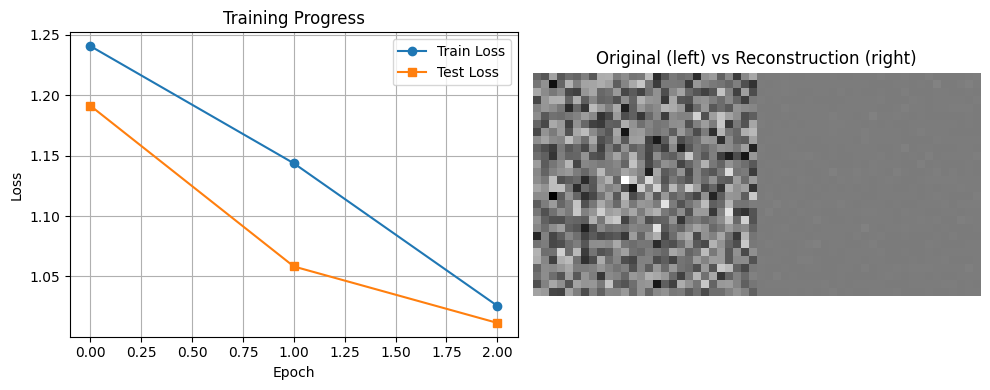

In [108]:
# Create synthetic dataset and run training
if 'test_config' in locals() and 'decoder' in locals():
    print("🎯 Creating synthetic dataset and running training...")
    
    # Create synthetic data based on config
    batch_size = config.data.batch_size
    image_size = model_config.decoder.output_size
    output_channels = model_config.decoder.output_channels
    
    # Generate synthetic images (random data for demonstration)
    n_train = n_train_samples
    n_test = n_test_samples
    
    train_images = torch.randn(n_train, output_channels, *image_size)
    test_images = torch.randn(n_test, output_channels, *image_size)
    
    print(f"  - Training data: {train_images.shape}")
    print(f"  - Test data: {test_images.shape}")
    
    # Create simple data loaders
    class SimpleDataset:
        def __init__(self, images):
            self.images = images
            self.length = len(images)
            
        def __len__(self):
            return self.length
            
        def __getitem__(self, idx):
            return idx, self.images[idx], 0  # index, image, dummy label
    
    train_dataset = SimpleDataset(train_images)
    test_dataset = SimpleDataset(test_images)
    
    # Create optimizers based on config
    optimizer_config = config.training.optimizer
    
    decoder_optimizer = torch.optim.Adam(
        decoder.parameters(), 
        lr=optimizer_config.decoder.lr
    )
    
    rep_optimizer = torch.optim.Adam(
        rep_layer.parameters(),
        lr=optimizer_config.representation.lr
    )
    
    test_rep_optimizer = torch.optim.Adam(
        test_rep_layer.parameters(),
        lr=optimizer_config.representation.lr
    )
    
    print(f"✅ Created optimizers:")
    print(f"  - Decoder: Adam (lr={optimizer_config.decoder.lr})")
    print(f"  - Representation: Adam (lr={optimizer_config.representation.lr})")
    
    # Simple training loop
    epochs = config.training.epochs
    print(f"\n🚀 Starting training for {epochs} epochs...")
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training phase
        epoch_train_loss = 0.0
        num_train_batches = 0
        
        for batch_start in range(0, n_train, batch_size):
            batch_end = min(batch_start + batch_size, n_train)
            batch_indices = torch.arange(batch_start, batch_end).to(device)
            batch_images = train_images[batch_start:batch_end].to(device)
            
            # Zero gradients
            decoder_optimizer.zero_grad()
            
            # Forward pass
            z = rep_layer(batch_indices)
            x_recon = decoder(z)
            
            # Compute loss (simple MSE)
            loss = nn.functional.mse_loss(x_recon, batch_images)
            
            # Backward pass
            loss.backward()
            decoder_optimizer.step()
            
            epoch_train_loss += loss.item()
            num_train_batches += 1
        
        # Update representations
        rep_optimizer.step()
        rep_optimizer.zero_grad()
        
        # Test phase
        epoch_test_loss = 0.0
        num_test_batches = 0
        
        with torch.no_grad():
            for batch_start in range(0, n_test, batch_size):
                batch_end = min(batch_start + batch_size, n_test)
                batch_indices = torch.arange(batch_start, batch_end).to(device)
                batch_images = test_images[batch_start:batch_end].to(device)
                
                # Forward pass
                z = test_rep_layer(batch_indices)
                x_recon = decoder(z)
                
                # Compute loss
                loss = nn.functional.mse_loss(x_recon, batch_images)
                epoch_test_loss += loss.item()
                num_test_batches += 1
        
        # Update test representations
        test_rep_optimizer.step()
        test_rep_optimizer.zero_grad()
        
        # Average losses
        avg_train_loss = epoch_train_loss / num_train_batches
        avg_test_loss = epoch_test_loss / num_test_batches
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        # Fit GMM periodically
        if epoch == config.training.first_epoch_gmm - 1:  # 0-indexed
            print(f"    Epoch {epoch + 1}: Fitting GMM...")
            with torch.no_grad():
                all_z = rep_layer.z.detach()
                gmm.fit(all_z.cpu())
        
        print(f"    Epoch {epoch + 1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")
    
    print(f"\n✅ Training completed!")
    print(f"  - Final train loss: {train_losses[-1]:.4f}")
    print(f"  - Final test loss: {test_losses[-1]:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    # Show sample reconstruction
    with torch.no_grad():
        sample_idx_cpu = torch.randint(0, n_test, (1,))  # Keep on CPU
        sample_idx_gpu = sample_idx_cpu.to(device)       # Copy to GPU for model
        sample_z = test_rep_layer(sample_idx_gpu)
        sample_recon = decoder(sample_z)
        
        # Get data using CPU index
        original = test_images[sample_idx_cpu].squeeze()
        reconstruction = sample_recon.cpu().squeeze()
        
        plt.subplot(1, 2, 2)
        if output_channels == 1:  # Grayscale
            plt.imshow(torch.cat([original, reconstruction], dim=1), cmap='gray')
        else:  # RGB
            plt.imshow(torch.cat([original, reconstruction], dim=2).permute(1, 2, 0))
        plt.title('Original (left) vs Reconstruction (right)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Components not available for training demonstration")

## 8. Configuration Merging and Composition

OmegaConf provides powerful features for composing complex configurations from simpler building blocks.

In [109]:
# Demonstrate configuration composition and merging
print("🔗 Configuration Composition Examples:")

# Example 1: Create a custom experiment config by merging base configs
if "Default" in configs and "Minimal" in configs:
    print("\n1. Merging Default + Minimal configurations:")
    
    # Take model architecture from default, but training schedule from minimal
    custom_config = OmegaConf.create({
        "experiment_name": "Custom_Hybrid_Experiment",
        "description": "Hybrid configuration: Default model + Minimal training"
    })
    
    # Start with default config
    base = OmegaConf.create(configs["Default"])
    
    # Override with minimal training settings
    training_overrides = {
        "training": {
            "epochs": configs["Minimal"].training.epochs,
            "first_epoch_gmm": configs["Minimal"].training.first_epoch_gmm,
        },
        "data": {
            "use_subset": configs["Minimal"].data.use_subset,
            "subset_fraction": configs["Minimal"].data.subset_fraction,
            "batch_size": configs["Minimal"].data.batch_size
        }
    }
    
    merged_config = OmegaConf.merge(base, custom_config, training_overrides)
    
    print(f"  - Model latent dim: {merged_config.model.representation.n_features} (from Default)")
    print(f"  - Training epochs: {merged_config.training.epochs} (from Minimal)")
    print(f"  - Use subset: {merged_config.data.use_subset} (from Minimal)")
    print(f"  - Experiment name: {merged_config.experiment_name} (custom)")

# Example 2: Create experiment variations
print("\n2. Creating experiment variations:")

if "Minimal" in configs:
    base_config = configs["Minimal"]
    
    # Create multiple experiment variants using direct override dictionaries
    variants = [
        {
            "name": "fast_test",
            "config": {
                "training": {"epochs": 2},
                "model": {"representation": {"n_features": 4}},
                "experiment_name": "Ultra_Fast_Test"
            }
        },
        {
            "name": "medium_test",
            "config": {
                "training": {"epochs": 10},
                "model": {"representation": {"n_features": 16}},
                "data": {"subset_fraction": 0.3},
                "experiment_name": "Medium_Test"
            }
        },
        {
            "name": "thorough_test",
            "config": {
                "training": {"epochs": 50},
                "model": {"representation": {"n_features": 32}},
                "data": {"subset_fraction": 0.5},
                "experiment_name": "Thorough_Test"
            }
        }
    ]
    
    for variant in variants:
        variant_name = variant["name"]
        override_config = OmegaConf.create(variant["config"])
        variant_config = OmegaConf.merge(base_config, override_config)
        
        print(f"  - {variant_name:15}: {variant_config.training.epochs:2} epochs, "
              f"{variant_config.model.representation.n_features:2}D latent, "
              f"{variant_config.data.subset_fraction:.1%} data")

# Example 3: Conditional configuration
print("\n3. Conditional configuration based on environment:")

if "Default" in configs:
    base_config = configs["Default"]
    
    # Different configs for different environments
    env_configs = {
        "development": {
            "training": {"epochs": 5},
            "data": {"use_subset": True, "subset_fraction": 0.1},
            "clearml": {"enabled": False},
            "experiment_name": "Dev_Test"
        },
        "testing": {
            "training": {"epochs": 20},
            "data": {"use_subset": True, "subset_fraction": 0.2},
            "clearml": {"enabled": False},
            "experiment_name": "Integration_Test"
        },
        "production": {
            "training": {"epochs": 500},
            "data": {"use_subset": False},
            "clearml": {"enabled": True},
            "experiment_name": "Production_Run"
        }
    }
    
    # Simulate different environments
    for env_name, env_overrides in env_configs.items():
        env_config = OmegaConf.merge(base_config, env_overrides)
        
        print(f"  - {env_name:12}: {env_config.training.epochs:3} epochs, "
              f"subset={env_config.data.use_subset}, "
              f"clearml={env_config.clearml.enabled}")

print("\n✅ Configuration composition examples completed!")

🔗 Configuration Composition Examples:

1. Merging Default + Minimal configurations:
  - Model latent dim: 32 (from Default)
  - Training epochs: 20 (from Minimal)
  - Use subset: True (from Minimal)
  - Experiment name: Custom_Hybrid_Experiment (custom)

2. Creating experiment variations:
  - fast_test      :  2 epochs,  4D latent, 10.0% data
  - medium_test    : 10 epochs, 16D latent, 30.0% data
  - thorough_test  : 50 epochs, 32D latent, 50.0% data

3. Conditional configuration based on environment:
  - development :   5 epochs, subset=True, clearml=False
  - testing     :  20 epochs, subset=True, clearml=False
  - production  : 500 epochs, subset=False, clearml=True

✅ Configuration composition examples completed!
  - medium_test    : 10 epochs, 16D latent, 30.0% data
  - thorough_test  : 50 epochs, 32D latent, 50.0% data

3. Conditional configuration based on environment:
  - development :   5 epochs, subset=True, clearml=False
  - testing     :  20 epochs, subset=True, clearml=Fal

## 9. Save and Export Modified Configurations

Finally, let's demonstrate how to save modified configurations and export summaries for experiment tracking.

In [110]:
# Saving and exporting configurations
print("💾 Saving and Exporting Configurations:")

# Create output directory for saved configs
output_dir = Path("config_outputs")
output_dir.mkdir(exist_ok=True)

# Example 1: Save modified configuration
if 'test_config' in locals():
    print("\n1. Saving modified configuration:")
    
    # Save as YAML
    config_path = output_dir / "test_config_modified.yaml"
    with open(config_path, 'w') as f:
        OmegaConf.save(test_config, f)
    
    print(f"  ✅ Saved modified config to: {config_path}")
    
    # Save as JSON (for programmatic access)
    json_path = output_dir / "test_config_modified.json"
    with open(json_path, 'w') as f:
        import json
        json.dump(OmegaConf.to_container(test_config, resolve=True), f, indent=2)
    
    print(f"  ✅ Saved as JSON to: {json_path}")

# Example 2: Create experiment summary
print("\n2. Creating experiment summary:")

def create_experiment_summary(config: DictConfig, results: dict = None) -> dict:
    """Create a comprehensive experiment summary."""
    summary = {
        "experiment_info": {
            "name": config.get('experiment_name', 'Unknown'),
            "description": config.get('description', 'No description'),
            "timestamp": str(np.datetime64('now'))
        },
        "data_config": {
            "dataset": config.data.dataset,
            "batch_size": config.data.batch_size,
            "use_subset": config.data.use_subset,
            "subset_fraction": config.data.get('subset_fraction', 1.0)
        },
        "model_config": {
            "latent_dim": config.model.representation.n_features,
            "distribution": config.model.representation.distribution,
            "decoder_hidden_dims": OmegaConf.to_container(config.model.decoder.hidden_dims),
            "gmm_components": config.model.gmm.n_components,
            "gmm_covariance_type": config.model.gmm.covariance_type
        },
        "training_config": {
            "epochs": config.training.epochs,
            "first_epoch_gmm": config.training.first_epoch_gmm,
            "lambda_gmm": config.training.lambda_gmm,
            "optimizers": {
                "decoder": {
                    "type": config.training.optimizer.decoder.type,
                    "lr": config.training.optimizer.decoder.lr,
                    "weight_decay": config.training.optimizer.decoder.get('weight_decay', 0.0)
                },
                "representation": {
                    "type": config.training.optimizer.representation.type,
                    "lr": config.training.optimizer.representation.lr,
                    "weight_decay": config.training.optimizer.representation.get('weight_decay', 0.0)
                }
            }
        }
    }
    
    # Add results if provided
    if results:
        summary["results"] = results
    
    return summary

if 'test_config' in locals():
    # Create summary with training results if available
    results = {}
    if 'train_losses' in locals():
        results = {
            "final_train_loss": float(train_losses[-1]),
            "final_test_loss": float(test_losses[-1]),
            "min_train_loss": float(min(train_losses)),
            "min_test_loss": float(min(test_losses)),
            "epochs_completed": len(train_losses)
        }
    
    summary = create_experiment_summary(test_config, results)
    
    # Save summary
    summary_path = output_dir / "experiment_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"  ✅ Experiment summary saved to: {summary_path}")
    
    # Pretty print summary
    print("\n📋 Experiment Summary:")
    print(f"  - Name: {summary['experiment_info']['name']}")
    print(f"  - Dataset: {summary['data_config']['dataset']}")
    print(f"  - Epochs: {summary['training_config']['epochs']}")
    print(f"  - Latent Dim: {summary['model_config']['latent_dim']}")
    print(f"  - GMM Components: {summary['model_config']['gmm_components']}")
    if results:
        print(f"  - Final Train Loss: {results['final_train_loss']:.4f}")
        print(f"  - Final Test Loss: {results['final_test_loss']:.4f}")

# Example 3: Configuration diff
print("\n3. Configuration differences:")

if "Default" in configs and "Minimal" in configs:
    def find_config_differences(config1, config2, path=""):
        """Find differences between two configurations."""
        differences = []
        
        # Convert to containers for easier comparison
        dict1 = OmegaConf.to_container(config1, resolve=True)
        dict2 = OmegaConf.to_container(config2, resolve=True)
        
        def compare_recursive(d1, d2, current_path):
            # Check all keys in d1
            for key in d1:
                new_path = f"{current_path}.{key}" if current_path else key
                if key not in d2:
                    differences.append(f"  - {new_path}: {d1[key]} (only in config1)")
                elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
                    compare_recursive(d1[key], d2[key], new_path)
                elif d1[key] != d2[key]:
                    differences.append(f"  - {new_path}: {d1[key]} -> {d2[key]}")
            
            # Check keys only in d2
            for key in d2:
                new_path = f"{current_path}.{key}" if current_path else key
                if key not in d1:
                    differences.append(f"  - {new_path}: {d2[key]} (only in config2)")
        
        compare_recursive(dict1, dict2, "")
        return differences
    
    diffs = find_config_differences(configs["Default"], configs["Minimal"])
    print(f"  Found {len(diffs)} differences between Default and Minimal configs:")
    for diff in diffs[:10]:  # Show first 10 differences
        print(diff)
    if len(diffs) > 10:
        print(f"  ... and {len(diffs) - 10} more differences")

# List all saved files
print(f"\n📁 Generated files in {output_dir}:")
if output_dir.exists():
    for file in output_dir.iterdir():
        if file.is_file():
            size_kb = file.stat().st_size / 1024
            print(f"  - {file.name} ({size_kb:.1f} KB)")
else:
    print("  No files generated")

print("\n✅ Configuration management demonstration completed!")

💾 Saving and Exporting Configurations:

1. Saving modified configuration:
  ✅ Saved modified config to: config_outputs/test_config_modified.yaml
  ✅ Saved as JSON to: config_outputs/test_config_modified.json

2. Creating experiment summary:
  ✅ Experiment summary saved to: config_outputs/experiment_summary.json

📋 Experiment Summary:
  - Name: Quick_Test_CLI_Style
  - Dataset: FashionMNIST
  - Epochs: 3
  - Latent Dim: 6
  - GMM Components: 3
  - Final Train Loss: 1.0257
  - Final Test Loss: 1.0116

3. Configuration differences:
  Found 42 differences between Default and Minimal configs:
  - experiment_name: ImageDGD_Default -> ImageDGD_Minimal_Test
  - description: Default ImageDGD training configuration -> Minimal configuration for fast testing and debugging
  - data.batch_size: 128 -> 512
  - data.num_workers: 4 -> 2
  - data.use_subset: False -> True
  - data.subset_fraction: 1.0 -> 0.1
  - model.representation.n_features: 32 -> 8
  - model.decoder.hidden_dims: [512, 256, 128, 64, 